In [7]:
using ITensors
using Plots

# Ground State MPS

In [2]:
function generate_aklt_mps(N::Int)
    # Create physical indices for each site with dimension 3 (spin-1)
    phys_indices = [Index(3, "S=1, Site, n=$n") for n in 1:N]

    # Create bond indices with dimension 2 for a 1D chain
    bond_indices = [Index(2, "Bond, n=$n") for n in 1:N]

    # Initialize a vector to store the MPS tensors
    tensors = Vector{ITensor}(undef, N)

    # Calculate the normalization factor
    norm_factor = 2/sqrt(3)

    # Define matrices corresponding to each physical index value, normalized
    matrices = [
        [0 1/sqrt(2) * norm_factor; 0 0],  # Matrix when physical index is 1, A+
        [-1/2 * norm_factor 0; 0 1/2 * norm_factor],  # Matrix when physical index is 2, A0
        [0 0; -1/sqrt(2) * norm_factor 0]  # Matrix when physical index is 3, A-
    ]

    # Assign matrix elements to each site
    for n in 1:N
        tensors[n] = ITensor(bond_indices[(n-1)%N+1], phys_indices[n], bond_indices[(n)%N+1])

        # Loop over physical index
        for p in 1:3
            # Loop over each element in the matrix
            for idx in CartesianIndices(matrices[p])
                # Access matrix element using idx and assign it to the tensor
                i, j = Tuple(idx)
                tensors[n][bond_indices[(n-1)%N+1] => i, phys_indices[n] => p, bond_indices[(n)%N+1] => j] = matrices[p][idx]
            end
        end
    end

    # Create the MPS with periodic boundary conditions
    psi_periodic = MPS(tensors)

    # Generalte AKLT Hamiltonian corresponding to this site number
    # Define Hamiltonian (nearest site spin-spin interaction)
    os = OpSum() 
    for j=1:N-1 
        # S*S Terms
        # Sz Sz
        os += "Sz", j, "Sz", j+1

        # S+ S- and S- S+
        os += 1/2, "S+", j, "S-", j+1
        os += 1/2, "S-", j, "S+", j+1

        # Square terms in (S*S)^2
        # (1/3) * (Sz Sz)^2 term
        os += (1/3), "Sz", j, "Sz", j+1, "Sz", j, "Sz", j+1
        # (1/3) * (1/4) (S+ S- S+ S-) term
        os += (1/3) * (1/4), "S+", j, "S-", j+1, "S+", j, "S-", j+1
        os += (1/3) * (1/4), "S-", j, "S+", j+1, "S-", j, "S+", j+1

        # Cross terms in (S*S)^2
        # (1/3) * (1/2) Sz Sz S+ S- terms
        os += (1/3) * (1/2), "Sz", j, "Sz", j+1, "S+", j, "S-", j+1
        os += (1/3) * (1/2), "S+", j, "S-", j+1, "Sz", j, "Sz", j+1

        # (1/3) * (1/2) Sz Sz S- S+ terms
        os += (1/3) * (1/2), "Sz", j, "Sz", j+1, "S-", j, "S+", j+1
        os += (1/3) * (1/2), "S-", j, "S+", j+1, "Sz", j, "Sz", j+1

        # (1/3) * (1/4) S+ S- S- S+ terms
        os += (1/3) * (1/4), "S+", j, "S-", j+1, "S-", j, "S+", j+1
        os += (1/3) * (1/4), "S-", j, "S+", j+1, "S+", j, "S-", j+1
    end

    # Generate Hamiltonian 
    H_AKLT = MPO(os, phys_indices)
    
    return psi_periodic, H_AKLT
end

generate_aklt_mps (generic function with 1 method)

# Energy

In [3]:
# Calculate ground state MPS and Hamiltonian
N = 10
psi_periodic, H_AKLT = generate_aklt_mps(N);

# Calculate energy
energy_temp = psi_periodic[1]*H_AKLT[1]*psi_periodic[1]';
for l in 2:N
    energy_temp *= psi_periodic[l]*H_AKLT[l]*psi_periodic[l]';
end
@show energy_temp

energy_temp = ITensor ord=0
NDTensors.Dense{Float64, Vector{Float64}}
 0-dimensional
-6.000304831580554


ITensor ord=0
NDTensors.Dense{Float64, Vector{Float64}}

# Entanglement Entropy

In [4]:
function entanglement_entropy(psi::MPS, b::Int)
  # Orthogonalize the MPS at site b
  psi = psi/norm(psi)
  psi = orthogonalize(psi, b)
  
  # Perform SVD on the tensor at site b
  U, S, V = svd(psi[b], (linkinds(psi, b-1)..., siteinds(psi, b)...))
  @show S[1], S[2], S[3], S[4]
  
  # Initialize the entanglement entropy
  SvN = 0.0
  
  # Calculate the von Neumann entropy
  for n in 1:dim(S, 1)
      p = S[n,n]^2
      if p > 1e-12  # Avoid numerical issues with very small p
          SvN -= p * log(p)
      end
  end
  
  return SvN
end

entanglement_entropy (generic function with 1 method)

In [5]:
# Calculate the entanglement entropy at site N/2
entropy = entanglement_entropy(psi_periodic, Int(N/2))
@show log(2)

(S[1], S[2], S[3], S[4]) = (0.7071067811865476, 0.0, 0.0, 0.7071067811865475)
log(2) = 0.6931471805599453


0.6931471805599453

Calculating for system size N = 2
(S[1], S[2], S[3], S[4]) = (0.5773502691896258, 0.0, 0.0, 0.0)
Entanglement entropy at bond 1 for N = 2: 1.0986122886681096
Calculating for system size N = 4
(S[1], S[2], S[3], S[4]) = (0.7071067811865476, 0.0, 0.0, 0.7071067811865475)
Entanglement entropy at bond 2 for N = 4: 0.6931471805599453
Calculating for system size N = 6
(S[1], S[2], S[3], S[4]) = (0.7071067811865476, 0.0, 0.0, 0.7071067811865475)
Entanglement entropy at bond 3 for N = 6: 0.6931471805599453
Calculating for system size N = 8
(S[1], S[2], S[3], S[4]) = (0.7071067811865476, 0.0, 0.0, 0.7071067811865475)
Entanglement entropy at bond 4 for N = 8: 0.6931471805599453
Calculating for system size N = 10
(S[1], S[2], S[3], S[4]) = (0.7071067811865476, 0.0, 0.0, 0.7071067811865475)
Entanglement entropy at bond 5 for N = 10: 0.6931471805599453
Calculating for system size N = 12
(S[1], S[2], S[3], S[4]) = (0.7071067811865476, 0.0, 0.0, 0.7071067811865475)
Entanglement entropy at bond 6 for 

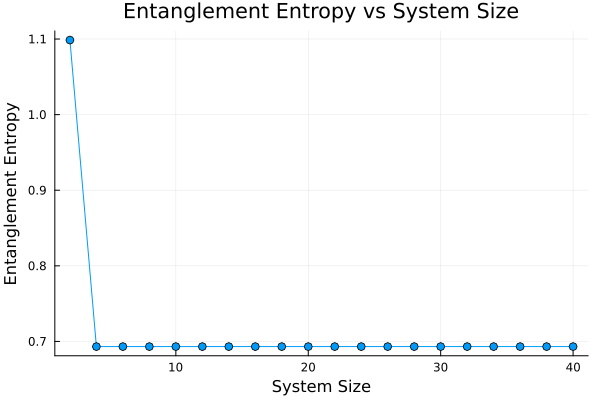

In [9]:
# Initialize arrays to store system sizes and entropy values
system_sizes = 2:2:40
entropy_list = Float64[]

# Iterate over different system sizes
for N in system_sizes
    println("Calculating for system size N = $N")

    # Generate the AKLT MPS for system size N
    psi, H = generate_aklt_mps(N)

    # Calculate the entanglement entropy at the middle bond
    b = Int(N/2)
    SvN = entanglement_entropy(psi, b)
    
    # Store the entropy value in the list
    push!(entropy_list, SvN)
    
    # Print the result
    println("Entanglement entropy at bond $b for N = $N: $SvN")
end

# Plot the entanglement entropy as a function of system size
plot(system_sizes, entropy_list, 
     marker=:o, 
     xlabel="System Size", 
     ylabel="Entanglement Entropy", 
     title="Entanglement Entropy vs System Size", 
     fontsize=14,
     legend=false,
     grid=true)